In [1]:
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-labs/quinlan/data-shared/constraint-tools'

In [2]:
import polars as pl

def get_halldorsson_windows_with_features():
    filename = f'{CONSTRAINT_TOOLS_DATA}/depletion_rank_scores/41586_2022_4965_MOESM3_ESM.overlapAmounts.bed'
    return (pl
        .read_csv(filename, separator='\t')
        .select(pl.col('Chr', 'Fromx', 'To', 'rank', 'feature', 'window_feature_overlap_bps'))
        .rename({
            'Chr': 'chromosome',
            'Fromx': 'start',
            'To': 'end',
            'rank': 'depletion_rank',        
        })
    )

halldorsson_windows_with_features = get_halldorsson_windows_with_features()
halldorsson_windows_with_features

chromosome,start,end,depletion_rank,feature,window_feature_overlap_bps
str,i64,i64,f64,str,i64
"""chr1""",777500,778000,0.59824,"""enhancer""",500
"""chr1""",777550,778050,0.649543,"""enhancer""",500
"""chr1""",777600,778100,0.682882,"""enhancer""",500
"""chr1""",777650,778150,0.572947,"""enhancer""",500
"""chr1""",777700,778200,0.502444,"""enhancer""",500
…,…,…,…,…,…
"""chr9""",138171800,138172300,0.309646,""".""",0
"""chr9""",138171850,138172350,0.508776,""".""",0
"""chr9""",138171900,138172400,0.672528,""".""",0


## Create single record for each window, with overlap amounts for each feature type 

In [3]:
columns_to_group_by = [column for column in halldorsson_windows_with_features.columns if column != 'window_feature_overlap_bps']
columns_to_group_by

['chromosome', 'start', 'end', 'depletion_rank', 'feature']

In [4]:
halldorsson_windows_with_features_grouped = ( 
    halldorsson_windows_with_features
    .group_by(columns_to_group_by, maintain_order=True)
    .agg(pl.col("window_feature_overlap_bps").sum())
)
halldorsson_windows_with_features_grouped

chromosome,start,end,depletion_rank,feature,window_feature_overlap_bps
str,i64,i64,f64,str,i64
"""chr1""",777500,778000,0.59824,"""enhancer""",500
"""chr1""",777550,778050,0.649543,"""enhancer""",500
"""chr1""",777600,778100,0.682882,"""enhancer""",500
"""chr1""",777650,778150,0.572947,"""enhancer""",500
"""chr1""",777700,778200,0.502444,"""enhancer""",500
…,…,…,…,…,…
"""chr9""",138171800,138172300,0.309646,""".""",0
"""chr9""",138171850,138172350,0.508776,""".""",0
"""chr9""",138171900,138172400,0.672528,""".""",0


In [5]:
pivot_index = [column for column in columns_to_group_by if column != 'feature']
pivot_index 

['chromosome', 'start', 'end', 'depletion_rank']

In [6]:
# pivoting is possible in SQL too, but it is clunky: https://www.databricks.com/blog/2018/11/01/sql-pivot-converting-rows-to-columns.html
halldorsson_windows_with_features_pivoted = (
    halldorsson_windows_with_features_grouped
    .pivot(
        index = pivot_index, 
        columns = "feature", 
        values = "window_feature_overlap_bps"
    )
    .drop('.')
    .rename({
        'enhancer': 'enhancer_overlap',
        'merged_exon': 'merged_exon_overlap',
    })
)
halldorsson_windows_with_features_pivoted

chromosome,start,end,depletion_rank,enhancer_overlap,merged_exon_overlap
str,i64,i64,f64,i64,i64
"""chr1""",777500,778000,0.59824,500,null
"""chr1""",777550,778050,0.649543,500,null
"""chr1""",777600,778100,0.682882,500,null
"""chr1""",777650,778150,0.572947,500,null
"""chr1""",777700,778200,0.502444,500,null
…,…,…,…,…,…
"""chr9""",138171800,138172300,0.309646,null,null
"""chr9""",138171850,138172350,0.508776,null,null
"""chr9""",138171900,138172400,0.672528,null,null


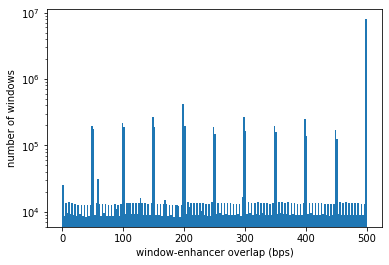

In [7]:
import matplotlib.pyplot as plt

def plot_distribution_of_overlap_amounts(feature): 
    data = halldorsson_windows_with_features_pivoted[f'{feature}_overlap']
    plt.hist(data, bins=200, log=True)
    plt.xlabel(f'window-{feature} overlap (bps)')
    plt.ylabel('number of windows')
    plt.show()
    
# Notice that there are peaks in the distribution at multiples of 50bp (which is the window step size)
# These correspond to starts and ends of certain enhancers, 
# presumably those called from a low-resolution tiling approach.
# The other category of enhancer has greater spatial resolution, 
# resulting in a uniform distribution of bp coverage, 
# as you might expect from features that are comparable in size to the windows 
plot_distribution_of_overlap_amounts(feature='enhancer')

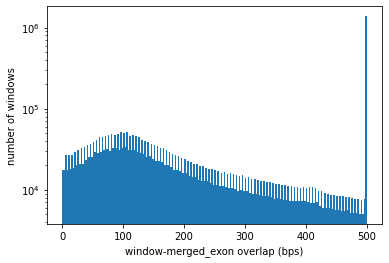

In [8]:
# Notice that the distribution is not uniform. 
# This is because exons are typically smaller than windows, 
# so that the overlap amounts reflect the exon sizes, 
# which are typically ~ 100bp 
plot_distribution_of_overlap_amounts(feature='merged_exon')

## Classify windows according to whether they appreciably overlap enhancers or exons 

In [9]:
def classify(df): 
    for feature, min_overlap in [
        ('enhancer', 250),
        ('merged_exon', 5),
    ]:
        df = df.with_columns(
            pl
            .when(pl.col(f'{feature}_overlap') >= min_overlap)
            .then(pl.lit("yes"))
            .when(pl.col(f'{feature}_overlap') < min_overlap)
            .then(pl.lit("ambiguous"))
            .otherwise(pl.lit("no"))
            .alias(f'window overlaps {feature}')
        )
    return df
    
halldorsson_windows_with_features_classified = classify(halldorsson_windows_with_features_pivoted)
halldorsson_windows_with_features_classified

chromosome,start,end,depletion_rank,enhancer_overlap,merged_exon_overlap,window overlaps enhancer,window overlaps merged_exon
str,i64,i64,f64,i64,i64,str,str
"""chr1""",777500,778000,0.59824,500,null,"""yes""","""no"""
"""chr1""",777550,778050,0.649543,500,null,"""yes""","""no"""
"""chr1""",777600,778100,0.682882,500,null,"""yes""","""no"""
"""chr1""",777650,778150,0.572947,500,null,"""yes""","""no"""
"""chr1""",777700,778200,0.502444,500,null,"""yes""","""no"""
…,…,…,…,…,…,…,…
"""chr9""",138171800,138172300,0.309646,null,null,"""no""","""no"""
"""chr9""",138171850,138172350,0.508776,null,null,"""no""","""no"""
"""chr9""",138171900,138172400,0.672528,null,null,"""no""","""no"""


In [10]:
halldorsson_windows_with_features_classified['window overlaps enhancer'].value_counts()

window overlaps enhancer,count
str,u32
"""yes""",10601308
"""no""",35376751
"""ambiguous""",3125967


In [11]:
halldorsson_windows_with_features_classified['window overlaps merged_exon'].value_counts()

window overlaps merged_exon,count
str,u32
"""no""",43927134
"""ambiguous""",34964
"""yes""",5141928


In [12]:
def throw_out_ambiguous(df):
    df = df.filter(
        (pl.col('window overlaps enhancer') != 'ambiguous') & 
        (pl.col('window overlaps merged_exon') != 'ambiguous')
    )
    for feature in ['enhancer', 'merged_exon']:
        df = df.with_columns(pl
            .when(pl.col(f'window overlaps {feature}') == 'yes')
            .then(pl.lit(True))
            .otherwise(pl.lit(False))
            .alias(f'window overlaps {feature}')
        )
    return df

halldorsson_windows_with_features_classified_unambiguous = throw_out_ambiguous(halldorsson_windows_with_features_classified)
halldorsson_windows_with_features_classified_unambiguous

chromosome,start,end,depletion_rank,enhancer_overlap,merged_exon_overlap,window overlaps enhancer,window overlaps merged_exon
str,i64,i64,f64,i64,i64,bool,bool
"""chr1""",777500,778000,0.59824,500,null,true,false
"""chr1""",777550,778050,0.649543,500,null,true,false
"""chr1""",777600,778100,0.682882,500,null,true,false
"""chr1""",777650,778150,0.572947,500,null,true,false
"""chr1""",777700,778200,0.502444,500,null,true,false
…,…,…,…,…,…,…,…
"""chr9""",138171800,138172300,0.309646,null,null,false,false
"""chr9""",138171850,138172350,0.508776,null,null,false,false
"""chr9""",138171900,138172400,0.672528,null,null,false,false


## Restrict to noncoding windows and save to disk 

In [13]:
(
    halldorsson_windows_with_features_classified_unambiguous
    .filter(pl.col('window overlaps merged_exon') == False)
    .drop('merged_exon_overlap')
    .drop('window overlaps merged_exon')
    .write_csv(
        f'{CONSTRAINT_TOOLS_DATA}/depletion_rank_scores/41586_2022_4965_MOESM3_ESM.noncoding.enhancer.bed',
        separator='\t'
    )
)